# Challenge Esame IA 2020 - Notebook  di Training

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

## STEP 1: Ricostruisco i dati splittati nel notebook di preparazione

### 1.1 caricamento file *.csv* contenenti i dati di train e test

In [3]:
path_file1 = './train.csv'
training_set = pd.read_csv(path_file1)

In [4]:
path_file2 = './test.csv'
test_set = pd.read_csv(path_file2)

In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PatientId       70736 non-null  float64
 1   AppointmentID   70736 non-null  int64  
 2   Gender          70736 non-null  object 
 3   ScheduledDay    70736 non-null  object 
 4   AppointmentDay  70736 non-null  object 
 5   Age             70736 non-null  int64  
 6   Neighbourhood   70736 non-null  object 
 7   Scholarship     70736 non-null  int64  
 8   Hipertension    70736 non-null  int64  
 9   Diabetes        70736 non-null  int64  
 10  Alcoholism      70736 non-null  int64  
 11  Handcap         70736 non-null  int64  
 12  SMS_received    70736 non-null  int64  
 13  No-show         70736 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 7.6+ MB


## STEP 2: Analisi features

## 2.0 Stampa dei tipi di ciascuna colonna

In [6]:
training_set.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

## 2.1 Analisi colonne numeriche

### 2.1.1 Ricerca di quanti valori nulli possiedono

In [7]:
numerical_columns = [col for col in training_set.columns if (training_set[col].dtype == 'int64' or training_set[col].dtype == 'float64')]
numerical_columns
for col in numerical_columns:
     print(col, training_set[col].isnull().sum()) 

PatientId 0
AppointmentID 0
Age 0
Scholarship 0
Hipertension 0
Diabetes 0
Alcoholism 0
Handcap 0
SMS_received 0


### 2.1.2 Stampa del totale dei valori unici

In [8]:
for col in training_set[numerical_columns]:
    print(col, training_set[col].nunique())

PatientId 46505
AppointmentID 70736
Age 102
Scholarship 2
Hipertension 2
Diabetes 2
Alcoholism 2
Handcap 5
SMS_received 2


### 2.1.3 Stampa di quali valori unici 

In [9]:
for col in training_set[numerical_columns]:
    print(col, training_set[col].unique())

PatientId [8.14723888e+14 2.88198615e+14 6.44899846e+13 ... 6.83862113e+13
 1.56651126e+12 4.64591132e+13]
AppointmentID [5648764 5679673 5522771 ... 5623378 5751411 5696925]
Age [ 22  79   0  50  15  56  64   1  19  91  54  16   8   6  32  40   7  62
  45   9  63  18  52  72  49  53  57  30  37  39  65  14   2  10  31  51
  55  23   3  25  20  13  67  27  61  33  29  59  38   5  34  21  74  58
  36  44  43   4  35  60  69  26  48  66  46  71  24  17  47  12  28  11
  89  41  75  83  42  70  90  76  73  77  80  78  84  88  68  86  92  87
  82 115  81  93  85  95  97  98  94  96 100  99]
Scholarship [0 1]
Hipertension [0 1]
Diabetes [0 1]
Alcoholism [0 1]
Handcap [0 1 2 4 3]
SMS_received [0 1]


### 2.1.4 Colonne *AppointmentID* e *PatientId*

Posso dropparle, sono gli identificativi rispettivamente dei pazienti e degli appuntamenti

### 2.1.5 Colonna *Age*

Ha tra gli unique values lo 0, analizzo che significato ha questo dato:

In [10]:
training_set[(training_set.Age <= 0) & ((training_set.Hipertension == 1) | (training_set.Alcoholism == 1))]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


La stampa delle righe relative a pazienti con età zero non evidenzia relazione con le patologie presenti tra le features. Posso dedurre che si tratta di bambini/neonati con nessuna patologia. Di conseguenza tratto questi pazienti come tutti quelli di altre età e non interpreto lo 0 come un valore nullo

Realizzo il grafico relativo alla probabilità che le persone si siano presentate all'appuntamento in funzione dell'età

In [11]:
#funzione per il calcolo della probabilità
def probabilityShow(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = training_set['No-show']).reset_index()
    df['probNoShow'] = df['No'] / (df['No'] + df['Yes'])
    return df[[group_by, 'probNoShow']]

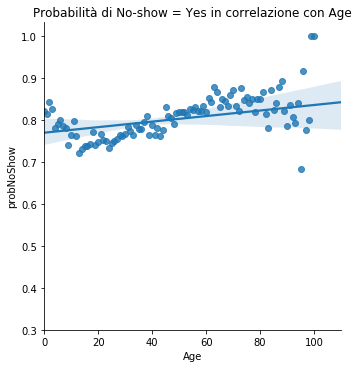

In [12]:
#grafico
sns.lmplot(data = probabilityShow(training_set, 'Age'), x = 'Age', y = 'probNoShow', fit_reg = True)
plt.xlim(0, 110)
plt.title('Probabilità di No-show = Yes in correlazione con Age')
plt.show()

Mediamente osservo che il comportamento dei pazienti è analogo nell'ambito di alcune fasce di età ben delineate: 
mediante *feature engineering* provo a suddividere i valori della colonna Age in tante fasce d'età, in corrispondenza delle variazioni più significative, e trasformo la colonna stessa da numerica a categorica.

In [13]:
def age_division(dataset) :
    if dataset['Age'] <= 10 :
        return 'Age0-10'
    elif (dataset['Age'] > 10) & (dataset['Age'] <= 35 ):
        return 'Age10-35'
    elif (dataset['Age'] > 35) & (dataset['Age'] <= 60) :
        return 'Age35-60'
    elif (dataset['Age'] > 60) & (dataset['Age'] <= 80) :
        return 'Age60-80'
    elif dataset['Age'] > 80 :
        return 'AgeOver80'
training_set['AgeAggregated'] = training_set.apply(lambda data: age_division(data),axis = 1)
training_set.drop(columns=['Age'], inplace = True) #ora Age non serve più

test_set['AgeAggregated'] = test_set.apply(lambda data: age_division(data),axis = 1)
test_set.drop(columns=['Age'], inplace = True)

In [14]:
print(training_set.AgeAggregated.unique())
print(test_set.AgeAggregated.unique())

['Age10-35' 'Age60-80' 'Age0-10' 'Age35-60' 'AgeOver80']
['Age0-10' 'Age60-80' 'Age35-60' 'Age10-35' 'AgeOver80']


## 2.2  Analisi colonne categoriche

### 2.2.1 Stampa del totale dei valori unici

In [15]:
categorical_columns = [col for col in training_set.columns if training_set[col].dtype == 'object']
unique_values = list(map(lambda col: training_set[col].nunique(), categorical_columns))
d = dict(zip(categorical_columns, unique_values))
sorted(d.items(), key=lambda x: x[1])

[('Gender', 2),
 ('No-show', 2),
 ('AgeAggregated', 5),
 ('AppointmentDay', 27),
 ('Neighbourhood', 81),
 ('ScheduledDay', 67706)]

### 2.2.2 Stampa di quali valori unici possiedono

In [16]:
for col in training_set[categorical_columns]:
    print(col, training_set[col].unique())

Gender ['F' 'M']
ScheduledDay ['2016-05-02T16:30:07Z' '2016-05-10T10:18:20Z' '2016-03-29T15:06:50Z' ...
 '2016-04-26T13:59:09Z' '2016-05-31T10:05:14Z' '2016-05-13T14:38:50Z']
AppointmentDay ['2016-05-05T00:00:00Z' '2016-05-13T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-20T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-17T00:00:00Z'
 '2016-05-19T00:00:00Z' '2016-06-01T00:00:00Z' '2016-05-11T00:00:00Z'
 '2016-05-24T00:00:00Z' '2016-06-08T00:00:00Z' '2016-06-03T00:00:00Z'
 '2016-05-03T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-02T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-07T00:00:00Z' '2016-04-29T00:00:00Z'
 '2016-05-18T00:00:00Z' '2016-05-31T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-06-06T00:00:00Z' '2016-05-06T00:00:00Z'
 '2016-05-12T00:00:00Z' '2016-05-25T00:00:00Z' '2016-05-14T00:00:00Z']
Neighbourhood ['MARIA ORTIZ' 'CONSOLAÇÃO' 'JESUS DE NAZARETH' 'BARRO VERMELHO'
 'ANDORINHAS' 'SANTO ANTÔNIO' 'SÃO PEDRO' 'RESISTÊNCIA' 'CENTRO'
 'JARDIM CAMBURI' 'JABOUR' 'SANTA M

### 2.2.3 Colonna *Gender* in correlazione con il target 

Costruisco il grafico che, raggruppando per genere, conta il totale dei valori per il target e ne estrae la percentuale

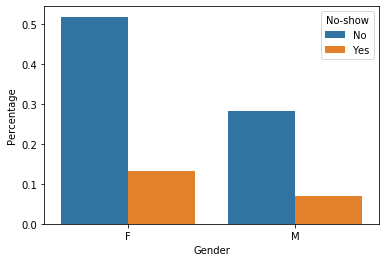

In [17]:
g = training_set.groupby('Gender')["No-show"].value_counts().to_frame()
g = g.rename({"No-show": 'Percentage'}, axis=1).reset_index()
g['Percentage'] = g['Percentage']/len(training_set)
ax = sns.barplot(x='Gender', y= 'Percentage', hue='No-show', data=g, orient='v')

Sul totale della popolazione il rapporto di proporzione tra uomini e donne che non si sono presentati all'appuntamento è uguale a quello delle persone che invece si sono presentate: circa il 63% della popolazione è femminile (51% non si è presentata - 12% si è presentata), il restante 37% è maschile (29% non si è presentata - 8% si è presentata). Possiamo dedurre che, in rapporto al target di predizione, 'Gender' non è una feature significativa

NB: in fase di creazione del modello, provando a droppare la feature non si rilevano significativi miglioramenti. Probabilmente, quindi, esistono altre correlazioni con altre features, non individuate, Gender quindi non viene droppata

### 2.2.4 *AppointmentDay* e *ScheduledDay*

Da sola la colonna ScheduledDay non è utile perché dalle stampe sopra eseguite si nota che possiede tutti valori unici che non si ripetono nel dataset, il modello perciò non imparerebbe molto da essa. 

Provo, ancora mediante *feature engineering*, a trasformare sia AppointmentDay sia ScheduledDay da object a datetime, in maniera da uniformarle (eliminando il problema delle ore 0.00 non fissate in AppointmentDay) e cercare di trarre vantaggio creando una nuova feature che rappresenta la differenza, in termini di giorni, tra il giorno in cui l'appuntamento è fissato dal paziente e il giorno dell'effettivo svolgimento del controllo medico. 

In [18]:
training_set['ScheduledDay'] = pd.to_datetime(training_set['ScheduledDay']).dt.date.astype('datetime64[ns]')
training_set['AppointmentDay'] = pd.to_datetime(training_set['AppointmentDay']).dt.date.astype('datetime64[ns]')

test_set['ScheduledDay'] = pd.to_datetime(test_set['ScheduledDay']).dt.date.astype('datetime64[ns]')
test_set['AppointmentDay'] = pd.to_datetime(test_set['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [19]:
diff_scheduled_to_appoint_train = training_set['AppointmentDay'] - training_set['ScheduledDay']
diff_scheduled_to_appoint_train = diff_scheduled_to_appoint_train.apply(lambda totGiorni: totGiorni.total_seconds()/(3600 * 24))
#uso total_seconds per trasformare il datetime in secondi, per misurare la distanza temporale
training_set = pd.concat([training_set, diff_scheduled_to_appoint_train], axis = 1)
training_set.rename(inplace = True, mapper = {0: 'diff_scheduled_to_appoint'}, axis = 1)
training_set.drop(['ScheduledDay'], axis = 1, inplace = True)
training_set.drop(['AppointmentDay'], axis = 1, inplace = True)


diff_scheduled_to_appoint_test = test_set['AppointmentDay'] - test_set['ScheduledDay']
diff_scheduled_to_appoint_test = diff_scheduled_to_appoint_test.apply(lambda totGiorni: totGiorni.total_seconds()/(3600 * 24))
test_set = pd.concat([test_set, diff_scheduled_to_appoint_test], axis = 1)
test_set.rename(inplace = True, mapper = {0: 'diff_scheduled_to_appoint'}, axis = 1)
test_set.drop(['ScheduledDay'], axis = 1, inplace = True)
test_set.drop(['AppointmentDay'], axis = 1, inplace = True)

Controllo che non ci siano anomalie generate dal calcolo della differenza tra i giorni

In [20]:
print(training_set.groupby('diff_scheduled_to_appoint').size())

diff_scheduled_to_appoint
-6.0          1
-1.0          2
 0.0      24719
 1.0       3345
 2.0       4322
          ...  
 155.0        5
 162.0        9
 169.0        6
 176.0        7
 179.0        6
Length: 126, dtype: int64


Posso droppare i valori negativi che sono privi di senso

In [21]:
training_set.drop(training_set[training_set['diff_scheduled_to_appoint'] < 0].index, inplace=True)
test_set.drop(test_set[test_set['diff_scheduled_to_appoint'] < 0].index, inplace=True)

Con l'aiuto di una funzione ausiliaria calcolo la probabilità che un paziente si sia presentato sulla base di quanto dista il giorno dell'appuntamento effettivo dal giorno in cui questo è stato prenotato.

In [22]:
def probabilityNoShow(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = training_set['No-show']).reset_index()
    df['probNoShow'] = df['No'] / (df['Yes'] + df['No'])
    return df[[group_by, 'probNoShow']]

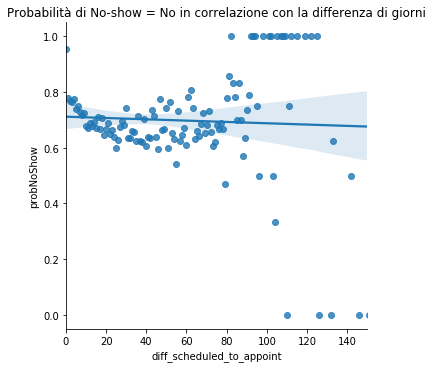

In [23]:
sns.lmplot(data = probabilityNoShow(training_set, 'diff_scheduled_to_appoint'), x = 'diff_scheduled_to_appoint', y = 'probNoShow', fit_reg = True)
plt.xlim(0, 150)
plt.title('Probabilità di No-show = No in correlazione con la differenza di giorni')
plt.show()

Il grafico mostra un'effettiva correlazione tra i giorni intercorsi tra la registrazione dell'appuntamento e il giorno effettivo dello stesso: meno giorni passano, più è probabile che i pazienti si presentino all'appuntamento fissato. Mi comporto come la colonna numerica Age, trasformandola in una categorica e cercando di trarre vantaggio dalla presenza dei suoi valori raggruppati per categorie

In [24]:
def diff_division(dataset) :
    if dataset['diff_scheduled_to_appoint'] <= 0:
        return 'Cat1'
    elif (dataset['diff_scheduled_to_appoint'] > 0) & (dataset['diff_scheduled_to_appoint'] <= 5):
        return 'Cat2'
    elif (dataset['diff_scheduled_to_appoint'] > 5) & (dataset['diff_scheduled_to_appoint'] <= 85):
        return 'Cat3'
    elif (dataset['diff_scheduled_to_appoint'] > 85):
        return 'Cat4'
training_set['diffAggregated'] = training_set.apply(lambda data: diff_division(data),axis = 1)
training_set.drop(columns=['diff_scheduled_to_appoint'], inplace = True) 

test_set['diffAggregated'] = test_set.apply(lambda data: diff_division(data),axis = 1)
test_set.drop(columns=['diff_scheduled_to_appoint'], inplace = True)

Spiegazione dei nuovi valori feature *diffAggregated*. La Cat1 rappresenta quelle persone che prenotano un appuntamento a brevissimo termine (il giorno dopo aver chiamato o il giorno stesso) e non si presentano (sono pochissime). Le ho separate dalla Cat2 perché si nota uno stacco evidente rispetto a quelle persone che invece prenotano e non si presentano comunque, ma la distanza distanza temporale è superiore di qualche giorno. La Cat3  rappresenta persone che hanno appuntamenti nel giro di poco meno di un mese ma non si presentano. La Cat4 invece non è particolarmente significativa perché rappresenta più o meno equamente persone che decidono di andare o meno all'appuntamento fissato (poiché i giorni di distanza aumentano, si può ipotizzare che la scelta del no, che è leggermente preponderante, dipenda da fattori esterni che hanno fatto desistere gli interessati). La Cat5 invece rappresenta tutte quelle persone che si sono presentate all'appuntamento nonostante sia passato già molto tempo da quando è stato fissato (probabile urgenza e necessità nonostante le lunghe scadenze).

In [25]:
print(test_set.diffAggregated.unique())
print(training_set.diffAggregated.unique())
training_set.nunique()

['Cat3' 'Cat2' 'Cat1' 'Cat4']
['Cat2' 'Cat3' 'Cat1' 'Cat4']


PatientId         46504
AppointmentID     70733
Gender                2
Neighbourhood        81
Scholarship           2
Hipertension          2
Diabetes              2
Alcoholism            2
Handcap               5
SMS_received          2
No-show               2
AgeAggregated         5
diffAggregated        4
dtype: int64

## STEP 2: Split dei dati 

In [26]:
y_train = training_set['No-show']
X_train = training_set.drop(['No-show', 'PatientId', 'AppointmentID', 'Neighbourhood'], axis = 1, inplace = False)

y_test = test_set['No-show']
X_test = test_set.drop(['No-show', 'PatientId', 'AppointmentID', 'Neighbourhood'], axis = 1, inplace = False)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70733 entries, 0 to 70735
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          70733 non-null  object
 1   Scholarship     70733 non-null  int64 
 2   Hipertension    70733 non-null  int64 
 3   Diabetes        70733 non-null  int64 
 4   Alcoholism      70733 non-null  int64 
 5   Handcap         70733 non-null  int64 
 6   SMS_received    70733 non-null  int64 
 7   AgeAggregated   70733 non-null  object
 8   diffAggregated  70733 non-null  object
dtypes: int64(6), object(3)
memory usage: 5.4+ MB



## STEP 3: Encoding delle features categoriche

## 3.1 Mi preoccupo di distinguere se esistono colonne nel test set che hanno valori sconosciuti rispetto a quelli presenti nel train set

In [27]:
numerical_columns = [col for col in X_train.columns if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64']
print('Numeriche',numerical_columns)

categorical_columns = [col for col in X_train.columns if X_train[col].dtype == "object"]
print('Categoriche', categorical_columns)

good_label_cols = [col for col in categorical_columns if set(X_train[col]) == set(X_test[col])]
print('Colonne categoriche non problematiche', good_label_cols)

bad_label_cols = list(set(X_test.columns)-set(good_label_cols)-set(numerical_columns))
print('Colonne catecorighe problematiche', bad_label_cols)

Numeriche ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
Categoriche ['Gender', 'AgeAggregated', 'diffAggregated']
Colonne categoriche non problematiche ['Gender', 'AgeAggregated', 'diffAggregated']
Colonne catecorighe problematiche []


Su Gender non ci sono problemi in linea teorica, su AgeAggregated e diffAggregated potrebbero presentarsi quando il modello è fatto girare su un nuovo set di test. Eseguo sulle due categoriche create nuove una visita dei loro valori e rimpiazzo con una stringa 'significativa' la presenza di valori classificati come sconosciuti, in modo da evitare problemi

In [28]:
encoder = LabelEncoder()
encoded_X_train = X_train
encoded_X_test = X_test

for col in set(categorical_columns):
    encoded_X_train[col] = encoder.fit_transform(encoded_X_train[col])
    for ind in test_set[col].index:
        if not test_set[col][ind] in encoder.classes_: #parametro che tiene le etichette (label) delle features
            test_set[col][ind] = 'notPresent'
    encoder.classes_ = numpy.append(encoder.classes_, 'notPresent')
    encoded_X_test[col] = encoder.transform(encoded_X_test[col])

## STEP 3: Creazione di più modelli dopo aver fatto la 'best parameter selection'

Dopo aver creato diversi modelli facendo su di essi la selezione dei parametri migliori, concludo dicendo che l'accuracy del modello DecisionTree è la migliore
Dopo aver fatto prove sulla base della feature importance stimata, ho notato netti miglioramenti su tutti i modelli creati per quanto riguarda le predizioni del Si. Soprattutto questa caratteristica mi ha incoraggiato ad usare questi modelli, anche se le prestazioni non sono ottimali ho voluto provare a migliorare non solo il predict del target No.

Ho notato, inoltre, come non droppare PatientId rendeva più alta l'accuracy, ma mi è sembrata un'operazione poco sensata data la natura della features. Restano comunque alcuni dubbi su questa colonna poiché i valori unici che essa possiede non sono tutti unici, dunque con essa il modello riesce ad apprendere qualcosa in più.

## 3.2 Logistic Regression

In [29]:
lr=LogisticRegression(max_iter = 200)
lr.fit(encoded_X_train,y_train)
predictions_final1 = lr.predict(encoded_X_test)
print(lr.score(X_test, y_test))

0.7956460277070964


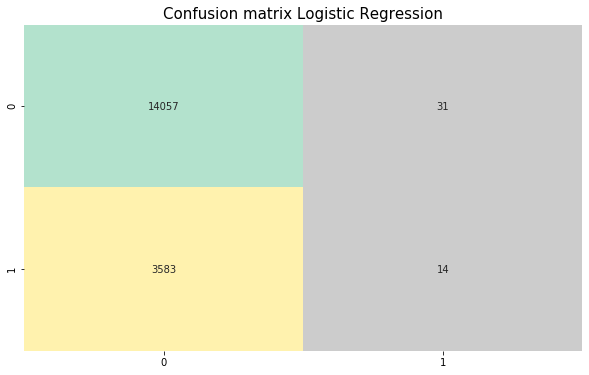

In [30]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_final1)
plt.figure(figsize = (10,6))

plt.subplot(1,1,1)
plt.title("Confusion matrix Logistic Regression", fontsize=15)
sns.heatmap(confusion_matrix, cbar = False, annot = True, cmap = "Pastel2_r", fmt = 'd')
plt.show()

## 3.3 KNN

In [31]:
knn=KNeighborsClassifier(n_neighbors = 18)
knn.fit(encoded_X_train,y_train)
predictions_final2 = knn.predict(encoded_X_test)
print(knn.score(X_test, y_test))

0.7898218829516539


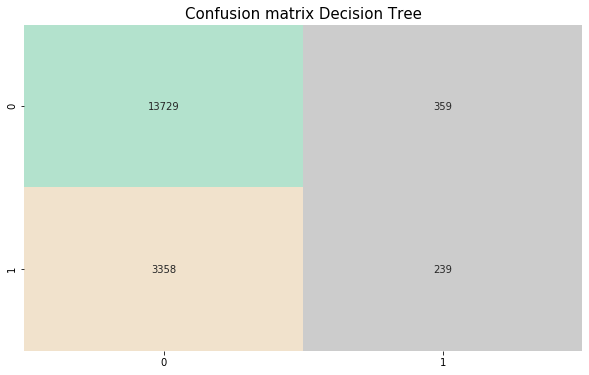

In [32]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_final2)
plt.figure(figsize = (10,6))

plt.subplot(1,1,1)
plt.title("Confusion matrix Decision Tree", fontsize=15)
sns.heatmap(confusion_matrix, cbar = False, annot = True, cmap = "Pastel2_r", fmt = 'd')
plt.show()

## Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 1)
dt.fit(encoded_X_train, y_train)
predictions = dt.predict(encoded_X_test)
print(dt.score(X_test, y_test))

0.7965507492225049


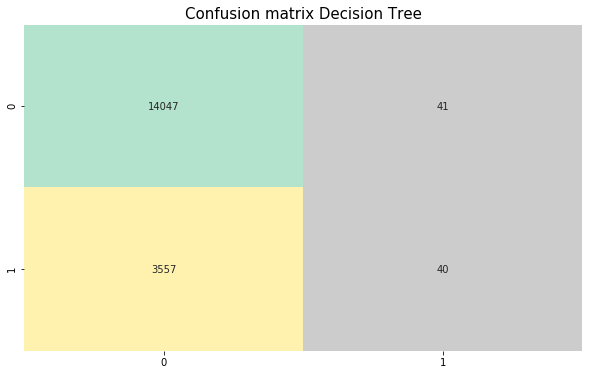

In [34]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize = (10,6))

plt.subplot(1,1,1)
plt.title("Confusion matrix Decision Tree", fontsize=15)
sns.heatmap(confusion_matrix, cbar = False, annot = True, cmap = "Pastel2_r", fmt = 'd')
plt.show()

# Best Accuracy: modello DecisionTree dt